## Instalación condicional de las bibliotecasInstalación condicional de las bibliotecas y manejo de advertencias

In [1]:
import sys
import subprocess
import warnings

In [2]:
# Lista de paquetes para instalar
packages = ['pandas', 'numpy', 'seaborn', 'matplotlib', 'scikit-learn', 'optuna']

In [3]:
# Función para instalar paquetes utilizando pip
def install(package):
    subprocess.check_call([sys.executable, "-m", "pip", "install", package])

In [4]:
# Comprobar e instalar paquetes si es necesario
for package in packages:
    try:
        __import__(package)
        print(f"{package} ya está instalado.")
    except ImportError:
        print(f"Instalando {package}...")
        install(package)

pandas ya está instalado.
numpy ya está instalado.
seaborn ya está instalado.
matplotlib ya está instalado.
Instalando scikit-learn...
Instalando optuna...
  Obtaining dependency information for optuna from https://files.pythonhosted.org/packages/15/da/68883911855d8b4d521f9a370e4e6aab8232b91c1d8d5a8348c4680c6642/optuna-3.6.1-py3-none-any.whl.metadata
  Using cached optuna-3.6.1-py3-none-any.whl.metadata (17 kB)
Using cached optuna-3.6.1-py3-none-any.whl (380 kB)


In [5]:
# Actualizar Seaborn y Pandas para evitar futuros warnings
subprocess.check_call([sys.executable, "-m", "pip", "install", "--upgrade", "seaborn", "pandas"])

0

In [6]:
# Ignorar advertencias específicas
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', message="When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas")
warnings.filterwarnings('ignore', message="The figure layout has changed to tight")

## Importación de librerías y carga de datos

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.decomposition import PCA
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import Ridge

# Cargar el dataset
wine = pd.read_csv('./winequality-red.csv')

## Carga y análisis exploratorio de datosAnálisis exploratorio de datos

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

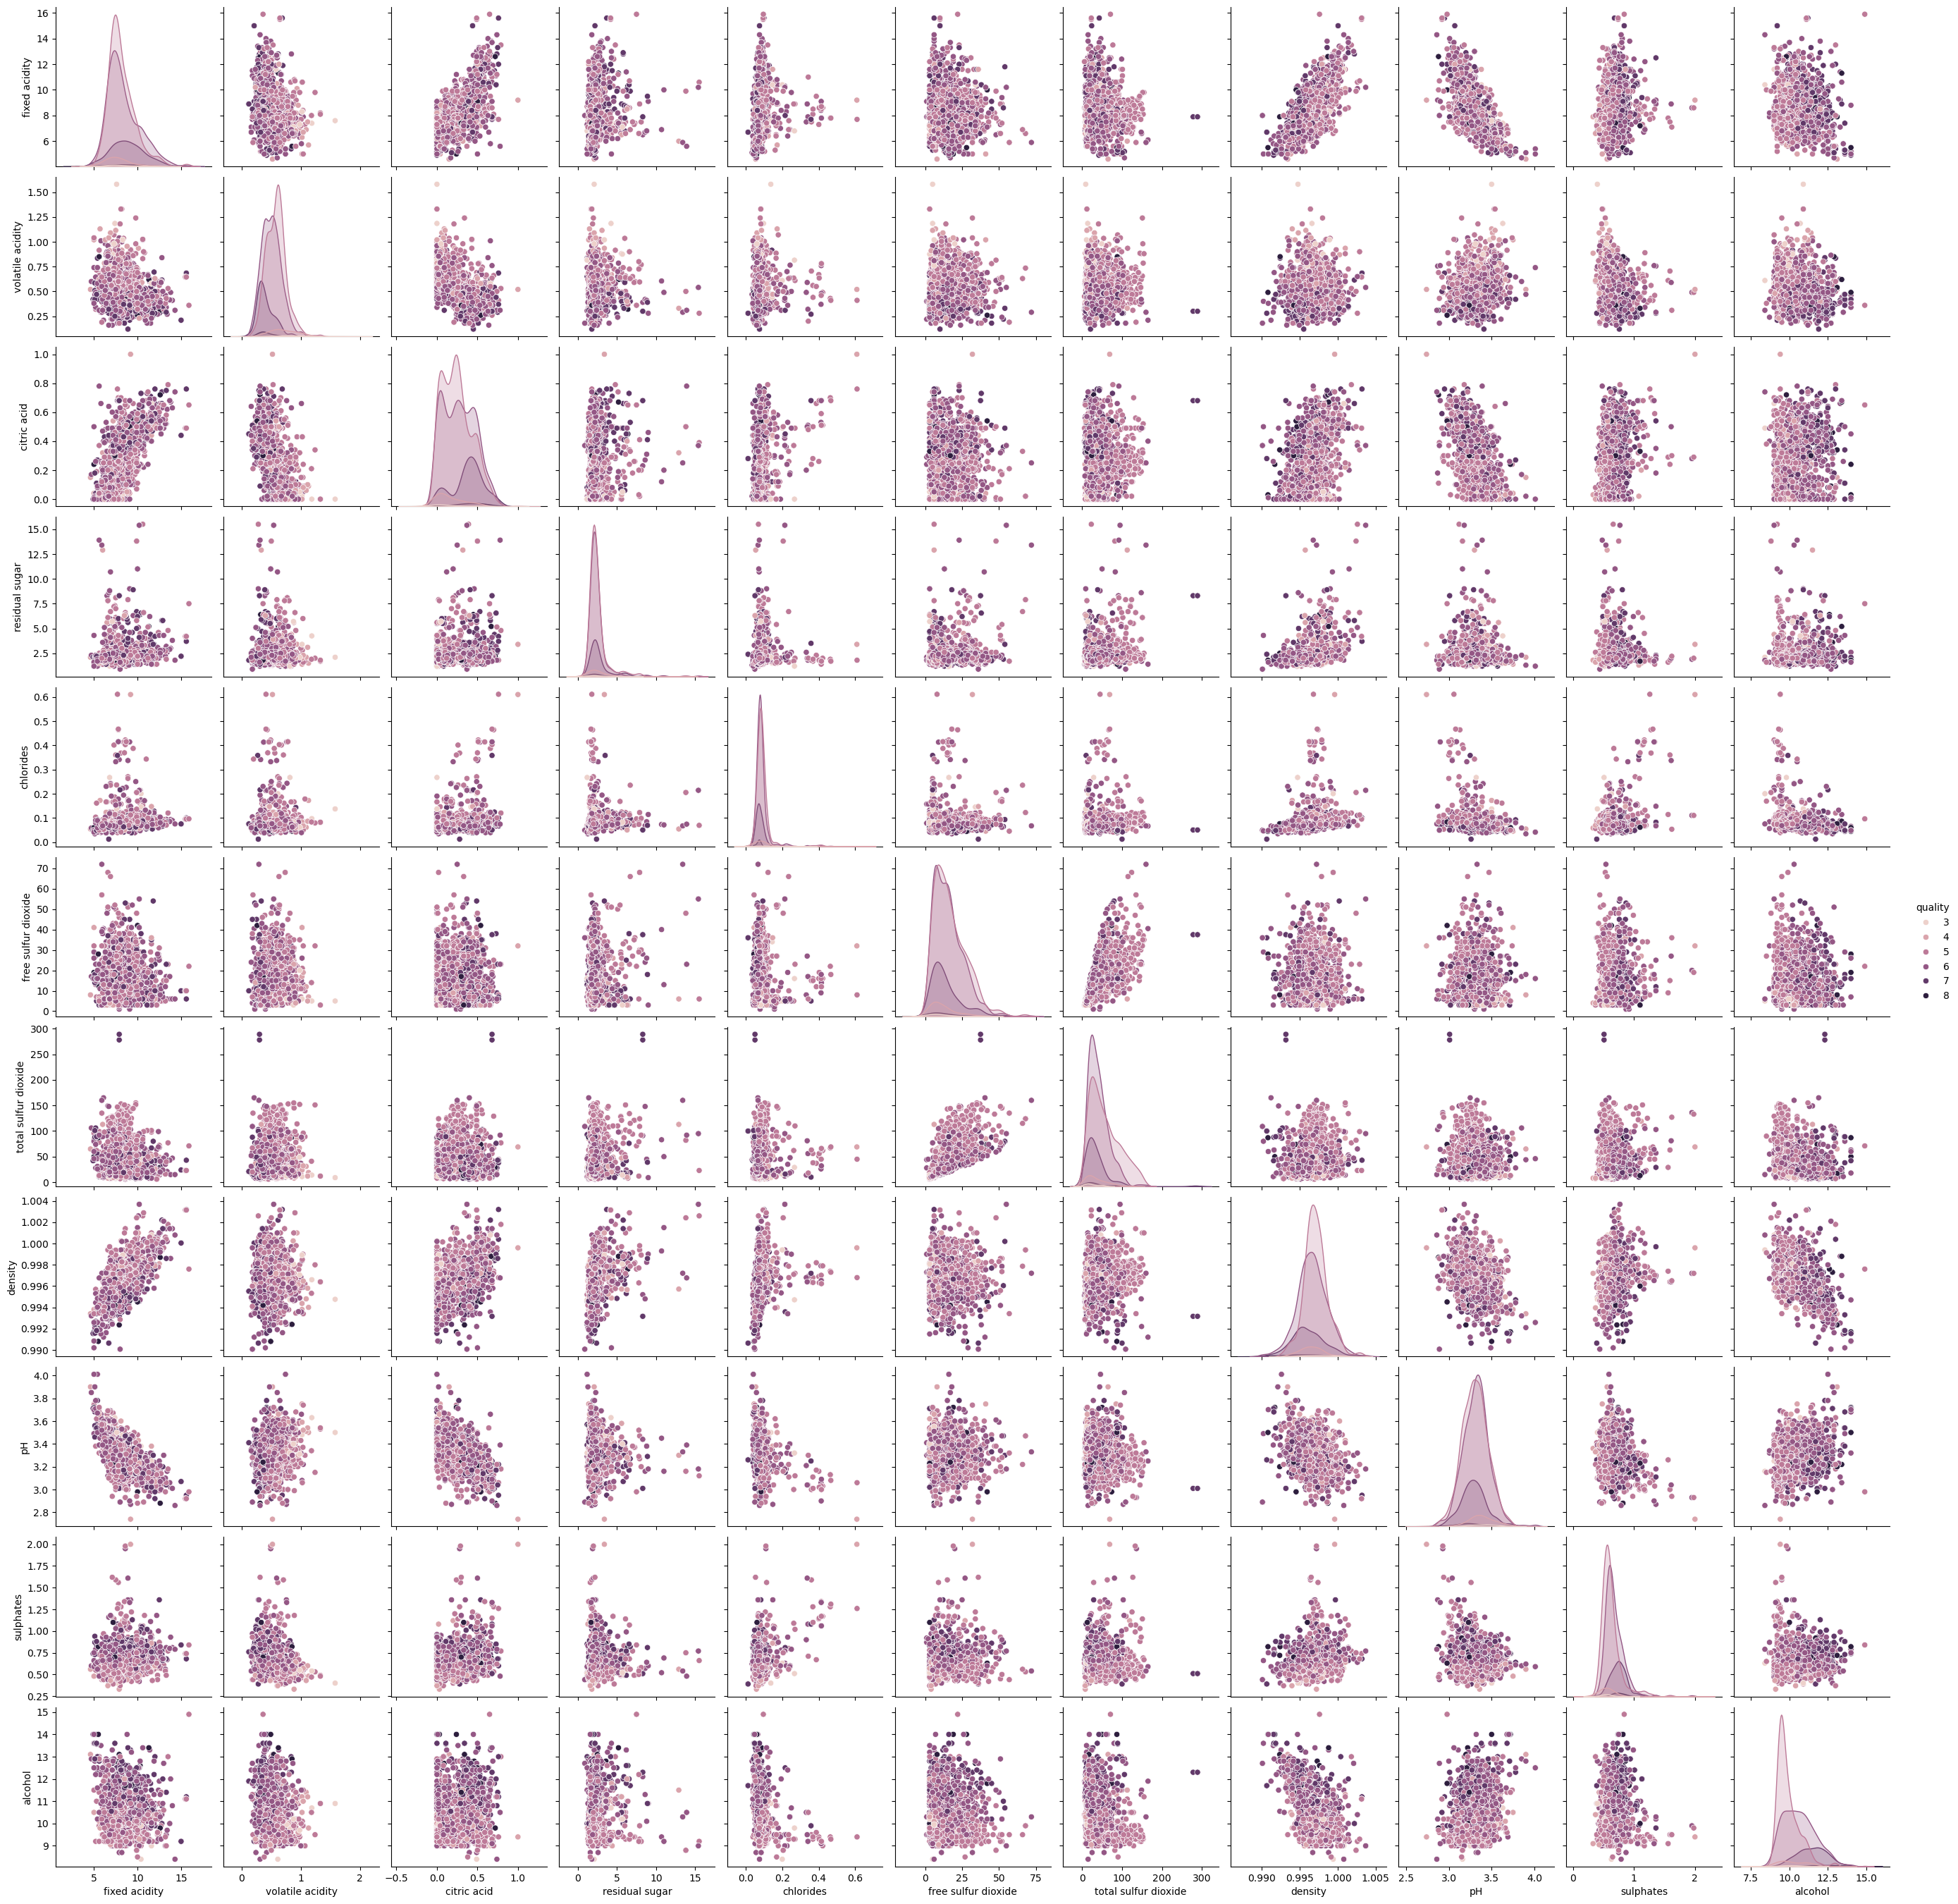

In [8]:
# Análisis exploratorio inicial
print(wine.describe())
sns.pairplot(wine, hue='quality')
plt.show()

## Creación de nuevas características y reducción de dimensionalidad

In [9]:
# Crear nuevas características
wine['interaction_acid_alcohol'] = wine['fixed acidity'] * wine['alcohol']
wine['total_acidity'] = wine['fixed acidity'] + wine['volatile acidity']
wine['sulfur_dioxide_ratio'] = wine['free sulfur dioxide'] / wine['total sulfur dioxide']


In [10]:
# Reducción de dimensionalidad con PCA
pca = PCA(n_components=2)
wine_pca = pca.fit_transform(wine.drop('quality', axis=1))
wine['pca_one'] = wine_pca[:,0]
wine['pca_two'] = wine_pca[:,1]

## Preparación de datos para el modelado

In [11]:
# División de los datos en entrenamiento y prueba
X = wine.drop('quality', axis=1)
y = wine['quality']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [12]:
# Escalado de características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Modelado y evaluación con Gradient Boosting

In [13]:
# Explicación del modelo Gradient Boosting
print("Modelado y evaluación con Gradient Boosting:")
print("Se utiliza el algoritmo de Gradient Boosting para realizar una regresión sobre los datos.")
print("Se configuran los siguientes hiperparámetros:")
print("- n_estimators: 100")
print("- learning_rate: 0.1")
print("- max_depth: 3")
print("- random_state: 42")
print("Se entrena el modelo con los datos de entrenamiento escalados.")

Modelado y evaluación con Gradient Boosting:
Se utiliza el algoritmo de Gradient Boosting para realizar una regresión sobre los datos.
Se configuran los siguientes hiperparámetros:
- n_estimators: 100
- learning_rate: 0.1
- max_depth: 3
- random_state: 42
Se entrena el modelo con los datos de entrenamiento escalados.


In [14]:
# Modelo de regresión con Gradient Boosting
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train_scaled, y_train)

GradientBoostingRegressor(random_state=42)

In [15]:
# Evaluación del modelo
y_pred = gbr.predict(X_test_scaled)

In [16]:
# Resultado de la evaluación
print("Resultado de la evaluación del modelo:")
print(f"MSE: {mean_squared_error(y_test, y_pred)}")
print(f"R2: {r2_score(y_test, y_pred)}")


Resultado de la evaluación del modelo:
MSE: 0.34359253137853407
R2: 0.47423190404575843


## Optimización de hiperparámetros con Optuna

In [17]:
# Optimización de hiperparámetros con Optuna
import optuna

def objective(trial):
    alpha = trial.suggest_uniform('alpha', 0.0, 1.0)
    model = Ridge(alpha=alpha)
    score = cross_val_score(model, X_train_scaled, y_train, n_jobs=-1, cv=3)
    return score.mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

# Explicación del resultado
print("Optimización de hiperparámetros con Optuna:")
print("Se han realizado 100 iteraciones para encontrar los mejores parámetros.")
print("Mejores parámetros encontrados:")
for key, value in study.best_trial.params.items():
    print(f"- {key}: {value}")


[I 2024-04-25 14:27:03,946] A new study created in memory with name: no-name-0b20386a-496e-41b9-9038-22d167df7aed
[I 2024-04-25 14:27:06,641] Trial 0 finished with value: 0.2906691569243944 and parameters: {'alpha': 0.25930367622397565}. Best is trial 0 with value: 0.2906691569243944.
[I 2024-04-25 14:27:08,154] Trial 1 finished with value: 0.29135102236781246 and parameters: {'alpha': 0.6105140656809172}. Best is trial 1 with value: 0.29135102236781246.
[I 2024-04-25 14:27:09,540] Trial 2 finished with value: 0.2908395883286163 and parameters: {'alpha': 0.3435613313143985}. Best is trial 1 with value: 0.29135102236781246.
[I 2024-04-25 14:27:09,560] Trial 3 finished with value: 0.2913055350190045 and parameters: {'alpha': 0.585873520652552}. Best is trial 1 with value: 0.29135102236781246.
[I 2024-04-25 14:27:09,578] Trial 4 finished with value: 0.2916256979329231 and parameters: {'alpha': 0.763247882297283}. Best is trial 4 with value: 0.2916256979329231.
[I 2024-04-25 14:27:09,592] 

Optimización de hiperparámetros con Optuna:
Se han realizado 100 iteraciones para encontrar los mejores parámetros.
Mejores parámetros encontrados:
- alpha: 0.9999884262152585


## Análisis comparativo de los mejores y peores vinos

In [18]:
# Análisis de los mejores y peores vinos
best_wines = wine[wine['quality'] >= 7]
worst_wines = wine[wine['quality'] <= 4]

In [19]:
# Características comunes de los mejores vinos
common_features_best = set(best_wines.columns) & set(worst_wines.columns)

In [20]:
# Imprimir resultados como lista
print("Características comunes de los mejores y peores vinos:")
for feature in common_features_best:
    print("- ", feature)

Características comunes de los mejores y peores vinos:
-  pca_one
-  volatile acidity
-  total sulfur dioxide
-  sulfur_dioxide_ratio
-  density
-  pH
-  quality
-  total_acidity
-  fixed acidity
-  chlorides
-  free sulfur dioxide
-  alcohol
-  residual sugar
-  pca_two
-  sulphates
-  interaction_acid_alcohol
-  citric acid


## Desinstalación de Optuna

In [21]:
# Desinstalación de Optuna
subprocess.check_call([sys.executable, "-m", "pip", "uninstall", "-y", "optuna"])

Found existing installation: optuna 3.6.1
Uninstalling optuna-3.6.1:
  Successfully uninstalled optuna-3.6.1


0